In [66]:
import numpy as np
import matplotlib.pyplot as plt


In [67]:
def f_true(x):
    return 0.03 * x ** 4 - 0.4 * x ** 2 + 0.7 * np.sin(2.2 * x)

def make_poly_features(x, degree):
    x = np.asarray(x).reshape(-1, 1)
    X = np.hstack([x ** i for i in range(degree + 1)])
    return X

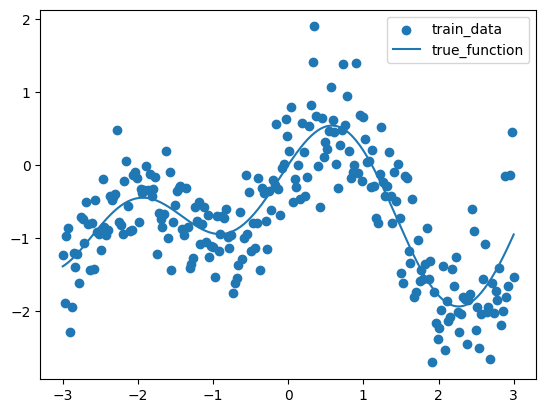

In [68]:
rng = np.random.default_rng(42)

N = 250
x = np.linspace(-3, 3, N)

sigma = 0.5
y = f_true(x) + rng.normal(0, sigma, size=x.shape)

degree = 15
X = make_poly_features(x, degree)

plt.scatter(x, y, label='train_data')
plt.plot(x, f_true(x), label='true_function')
plt.legend()
plt.show()

In [69]:
lamb = 1.0
alpha = 1.0 / (sigma ** 2)

M = X.shape[1]
posterior_cov_inv = lamb * np.eye(M) + alpha * (X.T @ X)

In [70]:
posterior_cov = np.linalg.inv(posterior_cov_inv)
mean = alpha * posterior_cov @ (X.T @ y)

In [71]:
x_new = np.linspace(-3, 3, 400)
X_new = make_poly_features(x_new, degree)

mean_pred = X_new @ mean
var_pred = 1.0 / alpha + np.sum(X_new @ posterior_cov @ X_new.T, axis=1)
std_pred = np.sqrt(var_pred)

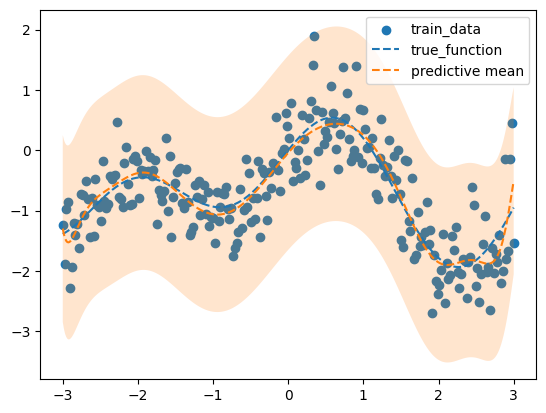

In [72]:
plt.scatter(x, y, label='train_data')
plt.plot(x_new, f_true(x_new), linestyle='--', label='true_function')
plt.plot(x_new, mean_pred, linestyle='--', label='predictive mean')

plt.fill_between(x_new, mean_pred - 2 * std_pred, mean_pred + 2 * std_pred, alpha=0.2)

plt.legend()
plt.show()

In [73]:
def log_evidence(X, y, alpha, lambdas):
    n, m = X.shape
    yTy = np.dot(y, y)
    Xt = X.T
    XtX = Xt @ X
    Xty = Xt @ y

    results = np.empty_like(lambdas, dtype=float)

    for i, lam in enumerate(lambdas):
        A = alpha * XtX
        np.fill_diagonal(A, np.diagonal(A) + lam)

        try:
            L = np.linalg.cholesky(A)
        except np.linalg.LinAlgError:
            results[i] = -np.inf
            continue

        logdet_A = 2.0 * np.sum(np.log(np.diag(L)))

        temp = np.linalg.solve(L, Xty)
        z = np.linalg.solve(L.T, temp)

        logdet_C = (n - m) * np.log(1 / alpha) - m * np.log(lam) + logdet_A

        quad_term = alpha * (yTy - alpha * np.dot(Xty, z))

        results[i] = -0.5 * (n * np.log(2 * np.pi) + logdet_C + quad_term)

    return results


Оптимальная λ: 13.5542


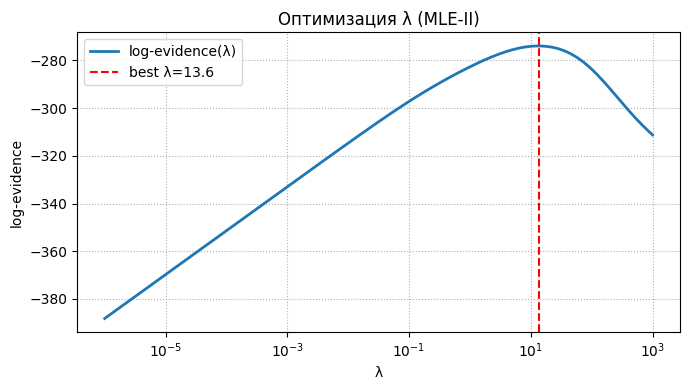

In [74]:
lambda_values = np.logspace(-6, 3, 160)

log_evs = log_evidence(X, y, alpha, lambda_values)

best_idx = np.nanargmax(log_evs)
best_lambda = lambda_values[best_idx]
print(f"Оптимальная λ: {best_lambda:.6g}")

plt.figure(figsize=(7,4))
plt.semilogx(lambda_values, log_evs, color='C0', lw=2, label='log-evidence(λ)')
plt.axvline(best_lambda, color='red', ls='--', label=f'best λ={best_lambda:.3g}')
plt.xlabel('λ')
plt.ylabel('log-evidence')
plt.title('Оптимизация λ (MLE-II)')
plt.legend()
plt.grid(True, which="both", linestyle=":")
plt.tight_layout()
plt.show()


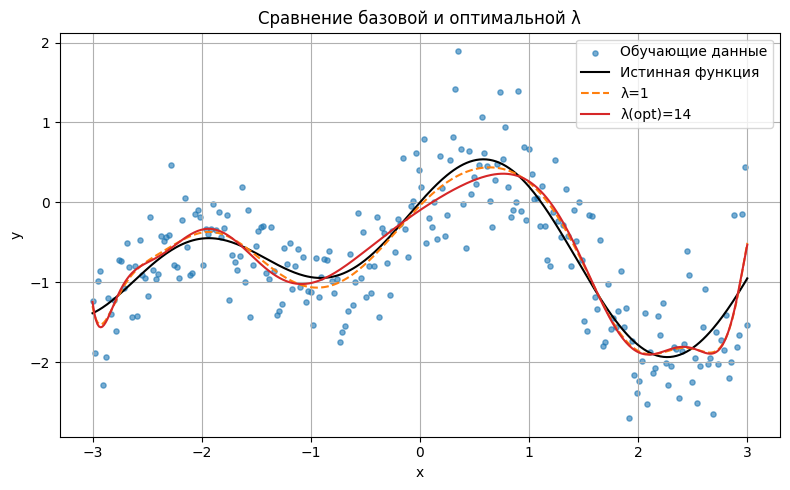

In [75]:
def posterior_weights(X, y, alpha, lam):
    A = alpha * (X.T @ X) + lam * np.eye(X.shape[1])
    return np.linalg.solve(A, alpha * X.T @ y)

def predict_model(X_new, w):
    return X_new @ w

base_lamb = 1
w_base = posterior_weights(X, y, alpha, base_lamb)
w_best = posterior_weights(X, y, alpha, best_lambda)

y_pred_base = predict_model(X_new, w_base)
y_pred_best = predict_model(X_new, w_best)

plt.figure(figsize=(8,5))
plt.scatter(x, y, s=14, color='C0', alpha=0.6, label='Обучающие данные')
plt.plot(x_new, f_true(x_new), color='k', linewidth=1.5, label='Истинная функция')
plt.plot(x_new, y_pred_base, '--', color='C1', label=f'λ={base_lamb:.2g}')
plt.plot(x_new, y_pred_best, '-', color='C3', label=f'λ(opt)={best_lambda:.2g}')
plt.legend()
plt.title('Сравнение базовой и оптимальной λ')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.tight_layout()
plt.show()
